In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns


In [2]:
from tslearn.piecewise import PiecewiseAggregateApproximation
from tslearn.piecewise import SymbolicAggregateApproximation
from tslearn.piecewise import OneD_SymbolicAggregateApproximation
from pyts.approximation import DiscreteFourierTransform

In [3]:
import pyts
from pyts import classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, RepeatedStratifiedKFold

from sklearn.metrics import make_scorer, accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from scikitplot.metrics import plot_roc
from sklearn.metrics import confusion_matrix

Classificazione da fare su: <br>
- Sax e dft la classificazione con knn delle emozioni
- classificazione binaria speech/song su uno dei due

Passaggi da fare: 
- importare la X_train corrispondente, e la y_train (di cui prendere solo la variabile che stiamo cercando di classificare)
- importare la X_test sulla quale è stata fatta la stessa approssimazione del train con la sua corrispondente y_test (di cui prendere solo la variabile che stiamo cercando di classificare)

In [4]:
x_test=np.load('RavdessAudioOnlyNumpy__X_test.npy')

In [5]:
x_test.shape

(624, 92672)

<h3>SAX - emotion</h3>

In [7]:
x_train_sax=np.load('X_train_sax.npy')
x_train_sax=np.squeeze(x_train_sax)
x_train_sax.shape

(1828, 500)

In [8]:
y_train=pd.read_csv('RavdessAudioOnlyNumpy__Y_train.csv')
y_train=y_train['emotion']

In [9]:
#faccio la stessa trasformazione SAX che avevo fatto per il train anche sul test
#SAX è stato fatto con 500 segmenti
n_sax_symbols = 50
sax = SymbolicAggregateApproximation(n_segments=500, 
                                     alphabet_size_avg=n_sax_symbols)
x_test_sax = sax.fit_transform(x_test)


/Users/dilettaferri/opt/anaconda3/lib/python3.9/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 624 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


In [10]:
x_test_sax.shape

(624, 500, 1)

In [11]:
x_test_sax=np.squeeze(x_test_sax)
x_test_sax.shape

(624, 500)

In [12]:
y_test=pd.read_csv('RavdessAudioOnlyNumpy__Y_test.csv')
y_test=y_test['emotion']
y_test

0      neutral
1      neutral
2      neutral
3      neutral
4         calm
        ...   
619    fearful
620    fearful
621    fearful
622    fearful
623    fearful
Name: emotion, Length: 624, dtype: object

In [24]:
#Facciamo una randomized search with 5-cross fold validation - caso knn con distanza manhattan/euclidea (che viene scelta nella cross validation)
param_dist = {
    'n_neighbors': (1,3,5,10,15,30,50),  # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'p': [1, 2],  # Power parameter for the Minkowski metric (1: Manhattan distance, 2: Euclidean distance)
}

knn=KNeighborsClassifier()
random_search = RandomizedSearchCV(knn, param_distributions=param_dist, n_iter=10, cv=5, random_state=42)
random_search.fit(x_train_sax, y_train)
random_search.best_params_


{'weights': 'distance', 'p': 1, 'n_neighbors': 50}

In [25]:
#alleno il modello con i migliori parametri:
knn_sax = KNeighborsClassifier(p=1, n_neighbors=50, weights="distance", n_jobs=-1)
knn_sax.fit(x_train_sax, y_train)

y_pred_sax= knn_sax.predict(x_test_sax)

print('Accuracy %s' % accuracy_score(y_test, y_pred_sax))
print('F1-score %s' % f1_score(y_test, y_pred_sax, average=None))
print(classification_report(y_test, y_pred_sax))

Accuracy 0.14583333333333334
F1-score [0.         0.24482109 0.         0.         0.18245614 0.
 0.         0.        ]
              precision    recall  f1-score   support

       angry       0.00      0.00      0.00        96
        calm       0.15      0.68      0.24        96
     disgust       0.00      0.00      0.00        48
     fearful       0.00      0.00      0.00        96
       happy       0.14      0.27      0.18        96
     neutral       0.00      0.00      0.00        48
         sad       0.00      0.00      0.00        96
   surprised       0.00      0.00      0.00        48

    accuracy                           0.15       624
   macro avg       0.04      0.12      0.05       624
weighted avg       0.04      0.15      0.07       624



/Users/dilettaferri/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dilettaferri/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dilettaferri/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

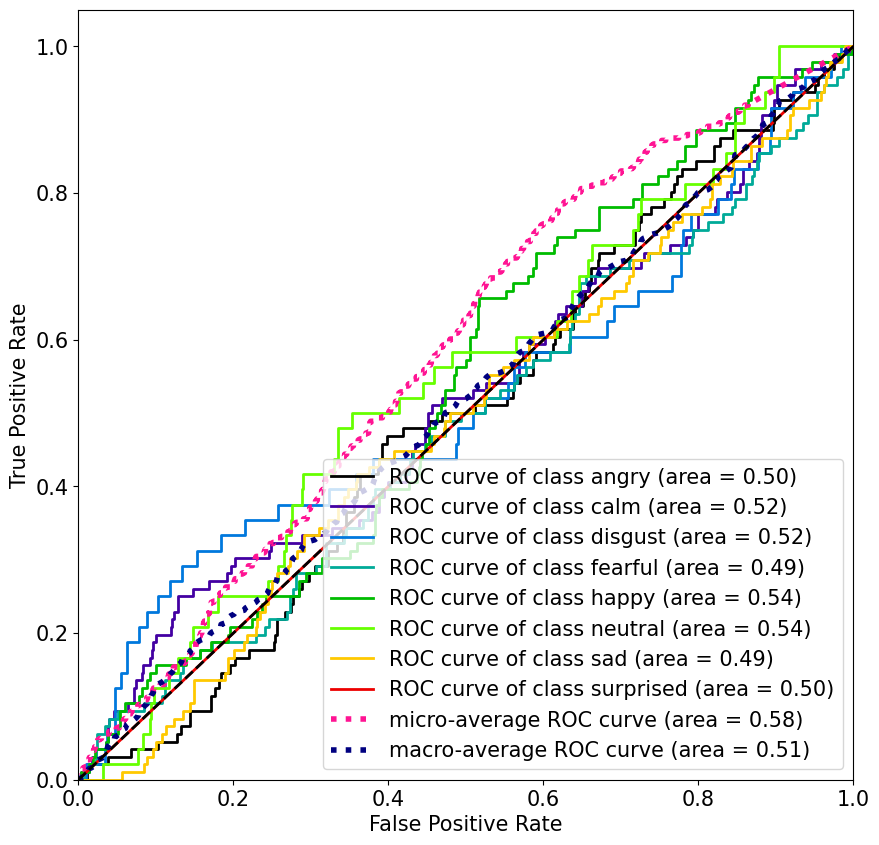

In [26]:
y_score_sax = knn_sax.predict_proba(x_test_sax)
plot_roc(y_test, y_score_sax, figsize=(10,10), title_fontsize=15, text_fontsize=15)
plt.title("")
plt.show()

array([[ 0, 73,  0,  0, 23,  0,  0,  0],
       [ 0, 65,  0,  0, 31,  0,  0,  0],
       [ 0, 33,  0,  0, 15,  0,  0,  0],
       [ 0, 65,  0,  0, 31,  0,  0,  0],
       [ 0, 70,  0,  0, 26,  0,  0,  0],
       [ 0, 37,  0,  0, 11,  0,  0,  0],
       [ 0, 60,  0,  0, 36,  0,  0,  0],
       [ 0, 32,  0,  0, 16,  0,  0,  0]])

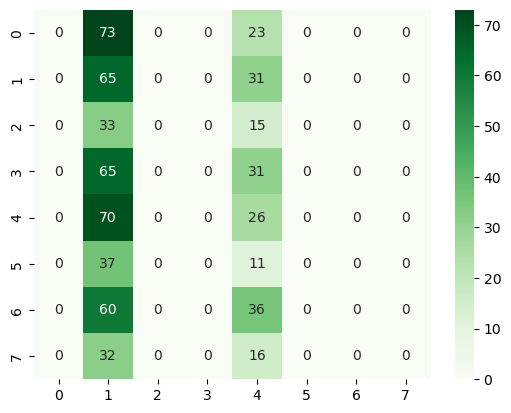

In [32]:
cm_sax = confusion_matrix(y_test, y_pred_sax)
sns.heatmap(cm_sax, annot=True, cmap="Greens")
cm_sax

<h5>KNN with DTW</h5>

In [13]:
from pyts.classification import KNeighborsClassifier #attenzione perchè si chiama uguale!!

In [ ]:
#Facciamo una randomized search with 5-cross fold validation - caso knn con distanze con DTW ("obbligando queste distanze")
param_dist = {
    'n_neighbors': (1,3,5,10,15,30,50),  # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
}

knn_dtw=KNeighborsClassifier(metric='dtw_fast') #provare con dtw_fast e dtw_sakoechiba - vedi qual è più veloce
random_search_dtw = RandomizedSearchCV(knn_dtw, param_distributions=param_dist, n_iter=5, cv=5, random_state=42)
random_search_dtw.fit(x_train_sax, y_train)
random_search_dtw.best_params_


In [14]:
#alleno il modello con i migliori parametri (da inserire da quello che esce nella cella sopra):
knn_sax_dtw = KNeighborsClassifier(metric='dtw_sakoechiba', n_neighbors=30, weights="uniform", n_jobs=-1)
knn_sax_dtw.fit(x_train_sax, y_train)

y_pred_sax_dtw= knn_sax_dtw.predict(x_test_sax)

print('Accuracy %s' % accuracy_score(y_test, y_pred_sax_dtw))
print('F1-score %s' % f1_score(y_test, y_pred_sax_dtw, average=None))
print(classification_report(y_test, y_pred_sax_dtw))

Accuracy 0.15384615384615385
F1-score [0.         0.26666667 0.         0.         0.         0.
 0.         0.        ]
              precision    recall  f1-score   support

       angry       0.00      0.00      0.00        96
        calm       0.15      1.00      0.27        96
     disgust       0.00      0.00      0.00        48
     fearful       0.00      0.00      0.00        96
       happy       0.00      0.00      0.00        96
     neutral       0.00      0.00      0.00        48
         sad       0.00      0.00      0.00        96
   surprised       0.00      0.00      0.00        48

    accuracy                           0.15       624
   macro avg       0.02      0.12      0.03       624
weighted avg       0.02      0.15      0.04       624



/Users/dilettaferri/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dilettaferri/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dilettaferri/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

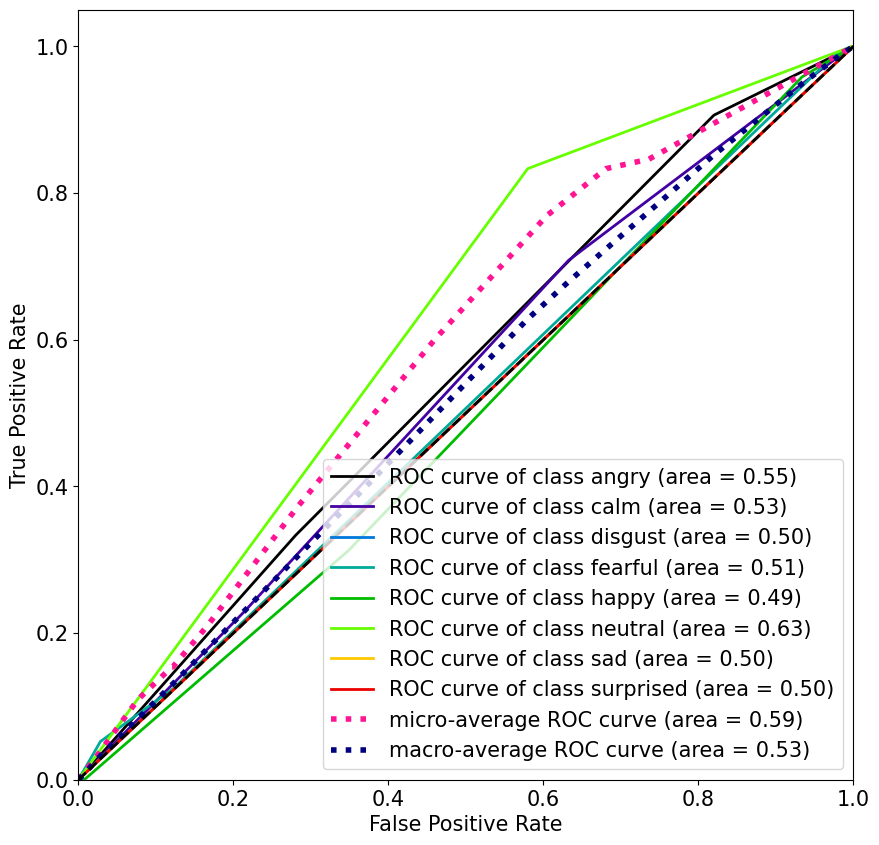

In [15]:
y_score_sax_dtw = knn_sax_dtw.predict_proba(x_test_sax)
plot_roc(y_test, y_score_sax_dtw, figsize=(10,10), title_fontsize=15, text_fontsize=15)
plt.title("")
plt.show()

array([[ 0, 96,  0,  0,  0,  0,  0,  0],
       [ 0, 96,  0,  0,  0,  0,  0,  0],
       [ 0, 48,  0,  0,  0,  0,  0,  0],
       [ 0, 96,  0,  0,  0,  0,  0,  0],
       [ 0, 96,  0,  0,  0,  0,  0,  0],
       [ 0, 48,  0,  0,  0,  0,  0,  0],
       [ 0, 96,  0,  0,  0,  0,  0,  0],
       [ 0, 48,  0,  0,  0,  0,  0,  0]])

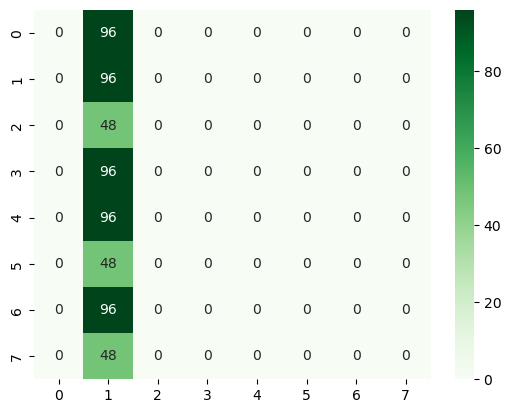

In [16]:
cm_sax_dtw = confusion_matrix(y_test, y_pred_sax_dtw)
sns.heatmap(cm_sax_dtw, annot=True, cmap="Greens")
cm_sax_dtw

<h3>DFT - emotion </h3>

In [18]:
x_train_dft=np.load('X_train_dft.npy')
x_train_dft.shape

(1828, 64)

In [19]:
y_train=pd.read_csv('RavdessAudioOnlyNumpy__Y_train.csv')
y_train=y_train['emotion']

In [20]:
x_test=np.nan_to_num(x_test, nan=0) #trasforma i nan in 0

In [21]:
dft = DiscreteFourierTransform(n_coefs=64)
x_test_dft = dft.fit_transform(x_test)

In [22]:
x_test_dft.shape

(624, 64)

In [23]:
y_test=pd.read_csv('RavdessAudioOnlyNumpy__Y_test.csv')
y_test=y_test['emotion']

<h5>KNN with euclidian/manhattan distances</h5>

In [50]:
#reimporto il knn "normale" che non ha il dynamic time warping
from sklearn.neighbors import KNeighborsClassifier


In [52]:
#Facciamo una randomized search with 5-cross fold validation - caso knn con distanza manhattan/euclidea (che viene scelta nella cross validation)
%time
param_dist = {
    'n_neighbors': (1,3,5,10,15,30,50),  # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'p': [1, 2],  # Power parameter for the Minkowski metric (1: Manhattan distance, 2: Euclidean distance)
}

knn=KNeighborsClassifier()
random_search = RandomizedSearchCV(knn, param_distributions=param_dist, n_iter=10, cv=5, random_state=42)
random_search.fit(x_train_dft, y_train)
random_search.best_params_

CPU times: user 7 µs, sys: 13 µs, total: 20 µs
Wall time: 14.1 µs


{'weights': 'uniform', 'p': 2, 'n_neighbors': 30}

In [53]:

#alleno il modello con i migliori parametri:
knn_dft = KNeighborsClassifier(p=2, n_neighbors=30, weights="uniform", n_jobs=-1)
knn_dft.fit(x_train_dft, y_train)

y_pred_dft= knn_dft.predict(x_test_dft)

print('Accuracy %s' % accuracy_score(y_test, y_pred_dft))
print('F1-score %s' % f1_score(y_test, y_pred_dft, average=None))
print(classification_report(y_test, y_pred_dft))

Accuracy 0.17147435897435898
F1-score [0.13559322 0.29714286 0.14285714 0.17808219 0.16129032 0.02739726
 0.1871345  0.15315315]
              precision    recall  f1-score   support

       angry       0.15      0.12      0.14        96
        calm       0.33      0.27      0.30        96
     disgust       0.14      0.15      0.14        48
     fearful       0.26      0.14      0.18        96
       happy       0.17      0.16      0.16        96
     neutral       0.04      0.02      0.03        48
         sad       0.21      0.17      0.19        96
   surprised       0.10      0.35      0.15        48

    accuracy                           0.17       624
   macro avg       0.17      0.17      0.16       624
weighted avg       0.19      0.17      0.17       624



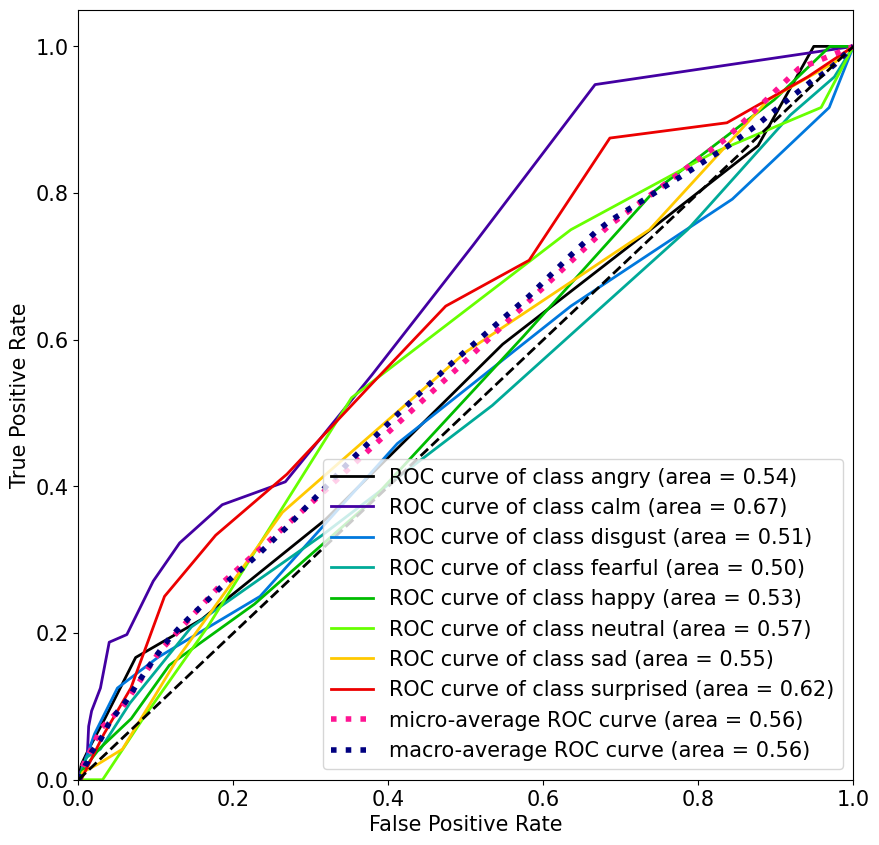

In [54]:
y_score_dft = knn_dft.predict_proba(x_test_dft)
plot_roc(y_test, y_score_dft, figsize=(10,10), title_fontsize=15, text_fontsize=15)
plt.title("")
plt.show()

array([[12,  5,  7, 11, 14,  9, 12, 26],
       [ 8, 26, 10,  4,  9,  7, 15, 17],
       [10,  3,  7,  1,  6,  0,  4, 17],
       [ 8, 10,  6, 13, 25,  1, 10, 23],
       [14,  7,  7,  8, 15,  2,  6, 37],
       [ 7,  7,  4,  5,  4,  1,  7, 13],
       [ 8, 18,  8,  7, 11,  4, 16, 24],
       [14,  3,  1,  1,  6,  1,  5, 17]])

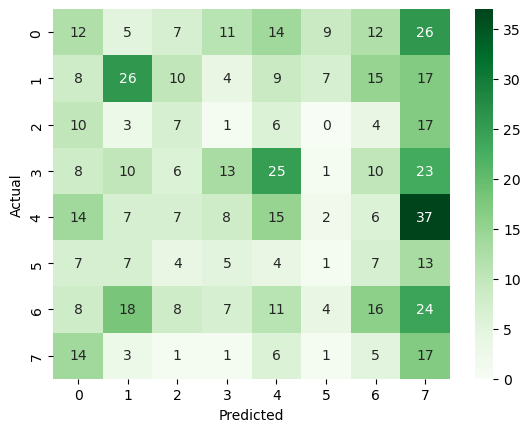

In [57]:
cm_dft = confusion_matrix(y_test, y_pred_dft)
sns.heatmap(cm_dft, annot=True, cmap="Greens")
plt.xlabel('Predicted')
plt.ylabel('Actual')
cm_dft

<h5>KNN with DTW</h5>

In [24]:
from pyts.classification import KNeighborsClassifier #attenzione perchè si chiama uguale!!

In [14]:
#alleno il modello con dei parametri di prova, per controllare che funzioni
knn_dft_dtw = KNeighborsClassifier(metric='dtw_fast', n_neighbors=30, weights="uniform", n_jobs=-1)
knn_dft_dtw.fit(x_train_dft, y_train)

y_pred_dft_dtw= knn_dft_dtw.predict(x_test_dft)

print('Accuracy %s' % accuracy_score(y_test, y_pred_dft_dtw))
print('F1-score %s' % f1_score(y_test, y_pred_dft_dtw, average=None))
print(classification_report(y_test, y_pred_dft_dtw))

Accuracy 0.17147435897435898
F1-score [0.13559322 0.29714286 0.14285714 0.17808219 0.16129032 0.02739726
 0.1871345  0.15315315]
              precision    recall  f1-score   support

       angry       0.15      0.12      0.14        96
        calm       0.33      0.27      0.30        96
     disgust       0.14      0.15      0.14        48
     fearful       0.26      0.14      0.18        96
       happy       0.17      0.16      0.16        96
     neutral       0.04      0.02      0.03        48
         sad       0.21      0.17      0.19        96
   surprised       0.10      0.35      0.15        48

    accuracy                           0.17       624
   macro avg       0.17      0.17      0.16       624
weighted avg       0.19      0.17      0.17       624



In [26]:
#Facciamo una randomized search with 5-cross fold validation - caso knn con distanze con DTW ("obbligando queste distanze")
param_dist = {
    'n_neighbors': (1,3,5,10,15,30,50),  # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
}

knn_dtw=KNeighborsClassifier(metric='dtw_sakoechiba') #provare con dtw_fast e dtw_sakoechiba - vedi qual è più veloce
random_search_dft_dtw = RandomizedSearchCV(knn_dtw, param_distributions=param_dist, n_iter=5, cv=5, random_state=42)
random_search_dft_dtw.fit(x_train_dft, y_train)
random_search_dft_dtw.best_params_

{'weights': 'distance', 'n_neighbors': 30}

In [27]:
#alleno con i parametri usciti dalla random search
knn_dft_dtw = KNeighborsClassifier(metric='dtw_sakoechiba', n_neighbors=30, weights="distance", n_jobs=-1)
knn_dft_dtw.fit(x_train_dft, y_train)

y_pred_dft_dtw= knn_dft_dtw.predict(x_test_dft)

print('Accuracy %s' % accuracy_score(y_test, y_pred_dft_dtw))
print('F1-score %s' % f1_score(y_test, y_pred_dft_dtw, average=None))
print(classification_report(y_test, y_pred_dft_dtw))

Accuracy 0.2467948717948718
F1-score [0.24242424 0.43621399 0.15929204 0.27878788 0.24880383 0.05555556
 0.11976048 0.19298246]
              precision    recall  f1-score   support

       angry       0.29      0.21      0.24        96
        calm       0.36      0.55      0.44        96
     disgust       0.14      0.19      0.16        48
     fearful       0.33      0.24      0.28        96
       happy       0.23      0.27      0.25        96
     neutral       0.08      0.04      0.06        48
         sad       0.14      0.10      0.12        96
   surprised       0.17      0.23      0.19        48

    accuracy                           0.25       624
   macro avg       0.22      0.23      0.22       624
weighted avg       0.24      0.25      0.24       624



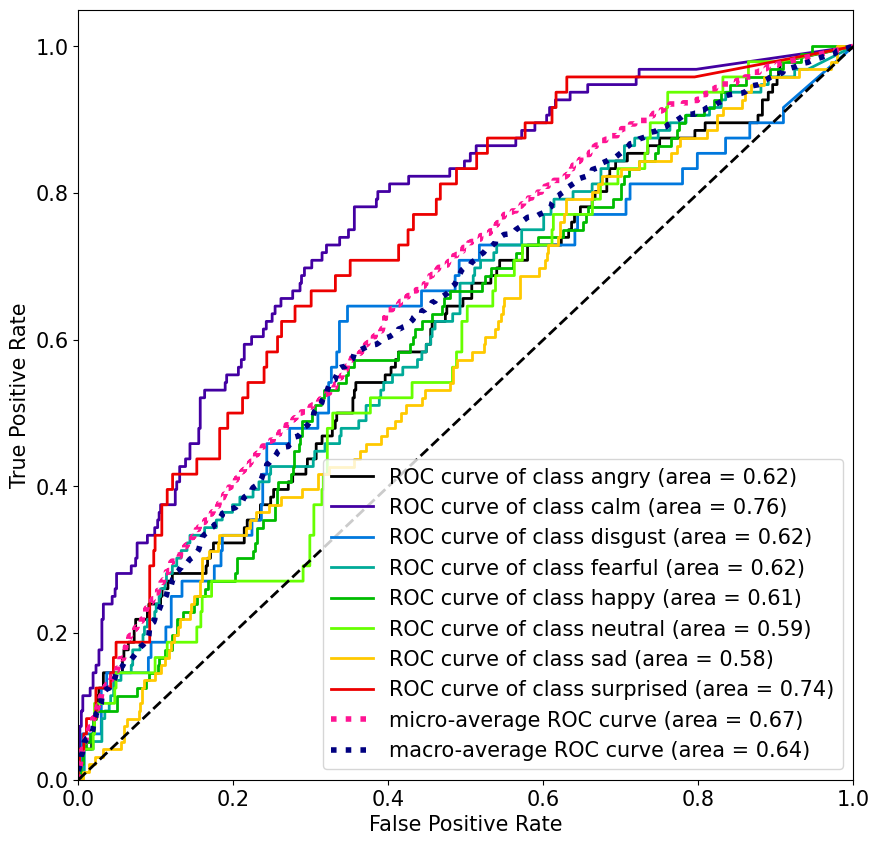

In [28]:
y_score_dft_dtw = knn_dft_dtw.predict_proba(x_test_dft)
plot_roc(y_test, y_score_dft_dtw, figsize=(10,10), title_fontsize=15, text_fontsize=15)
plt.title("")
plt.show()

array([[20,  9, 10, 18, 15,  4, 10, 10],
       [ 3, 53,  9,  2, 14,  3, 11,  1],
       [10,  5,  9,  1,  4,  5,  7,  7],
       [13, 17,  5, 23, 18,  1,  6, 13],
       [11, 13,  8, 10, 26,  1, 11, 16],
       [ 3, 12,  7,  1, 10,  2, 11,  2],
       [ 6, 37, 10,  8, 12,  7, 10,  6],
       [ 3,  1,  7,  6, 14,  1,  5, 11]])

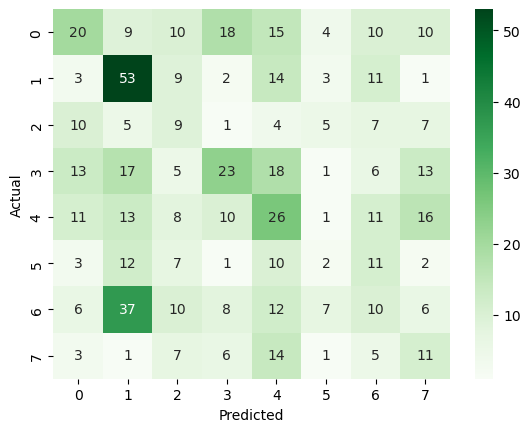

In [29]:
cm_dft_dtw = confusion_matrix(y_test, y_pred_dft_dtw)
sns.heatmap(cm_dft_dtw, annot=True, cmap="Greens")
plt.xlabel('Predicted')
plt.ylabel('Actual')
cm_dft_dtw

<h3>DFT - speech/song</h3>

In [30]:
#il train e test sono già definiti sopra: sono x_train_dft e x_test_dft - controllo lo shape
print(x_train_dft.shape)
print(x_test_dft.shape)

(1828, 64)
(624, 64)


In [31]:
y_train_s=pd.read_csv('RavdessAudioOnlyNumpy__Y_train.csv')
y_train_s


,modality,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,sex,filename
0,audio-only,speech,neutral,normal,Kids are talking by the door,1st,1,M,03-01-01-01-01-01-01.wav
1,audio-only,speech,neutral,normal,Kids are talking by the door,2nd,1,M,03-01-01-01-01-02-01.wav
2,audio-only,speech,neutral,normal,Viva il che,1st,1,M,03-01-01-01-02-01-01.wav
3,audio-only,speech,neutral,normal,Viva il che,2nd,1,M,03-01-01-01-02-02-01.wav
4,audio-only,speech,calm,normal,Kids are talking by the door,1st,1,M,03-01-02-01-01-01-01.wav
...,...,...,...,...,...,...,...,...,...
1823,audio-only,speech,surprised,normal,Viva il che,2nd,18,F,03-01-08-01-02-02-18.wav
1824,audio-only,speech,surprised,strong,Kids are talking by the door,1st,18,F,03-01-08-02-01-01-18.wav
1825,audio-only,speech,surprised,strong,Kids are talking by the door,2nd,18,F,03-01-08-02-01-02-18.wav
1826,audio-only,speech,surprised,strong,Viva il che,1st,18,F,03-01-08-02-02-01-18.wav


In [32]:
y_train_s=y_train_s['vocal_channel']

In [33]:
y_test_s=pd.read_csv('RavdessAudioOnlyNumpy__Y_test.csv')
y_test_s=y_test_s['vocal_channel']

<h5>KNN euclidean/manhattan distances</h5>

In [66]:
#reimporto il knn "normale" che non ha il dynamic time warping
from sklearn.neighbors import KNeighborsClassifier


In [67]:
#Facciamo una randomized search with 5-cross fold validation - caso knn con distanza manhattan/euclidea (che viene scelta nella cross validation)
%time
param_dist = {
    'n_neighbors': (1,3,5,10,15,30,50),  # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'p': [1, 2],  # Power parameter for the Minkowski metric (1: Manhattan distance, 2: Euclidean distance)
}

knn=KNeighborsClassifier()
random_search_s = RandomizedSearchCV(knn, param_distributions=param_dist, n_iter=10, cv=5, random_state=42)
random_search_s.fit(x_train_dft, y_train_s)
random_search_s.best_params_

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 9.06 µs


{'weights': 'uniform', 'p': 1, 'n_neighbors': 1}

In [70]:
#alleno il modello con i migliori parametri:
knn_dft_s = KNeighborsClassifier(p=1, n_neighbors=1, weights="uniform", n_jobs=-1)
knn_dft_s.fit(x_train_dft, y_train_s)

y_pred_dft_s= knn_dft_s.predict(x_test_dft)

print('Accuracy %s' % accuracy_score(y_test_s, y_pred_dft_s))
print('F1-score %s' % f1_score(y_test_s, y_pred_dft_s, average=None))
print(classification_report(y_test_s, y_pred_dft_s))

Accuracy 0.6474358974358975
F1-score [0.43298969 0.74418605]
              precision    recall  f1-score   support

        song       0.68      0.32      0.43       264
      speech       0.64      0.89      0.74       360

    accuracy                           0.65       624
   macro avg       0.66      0.60      0.59       624
weighted avg       0.66      0.65      0.61       624



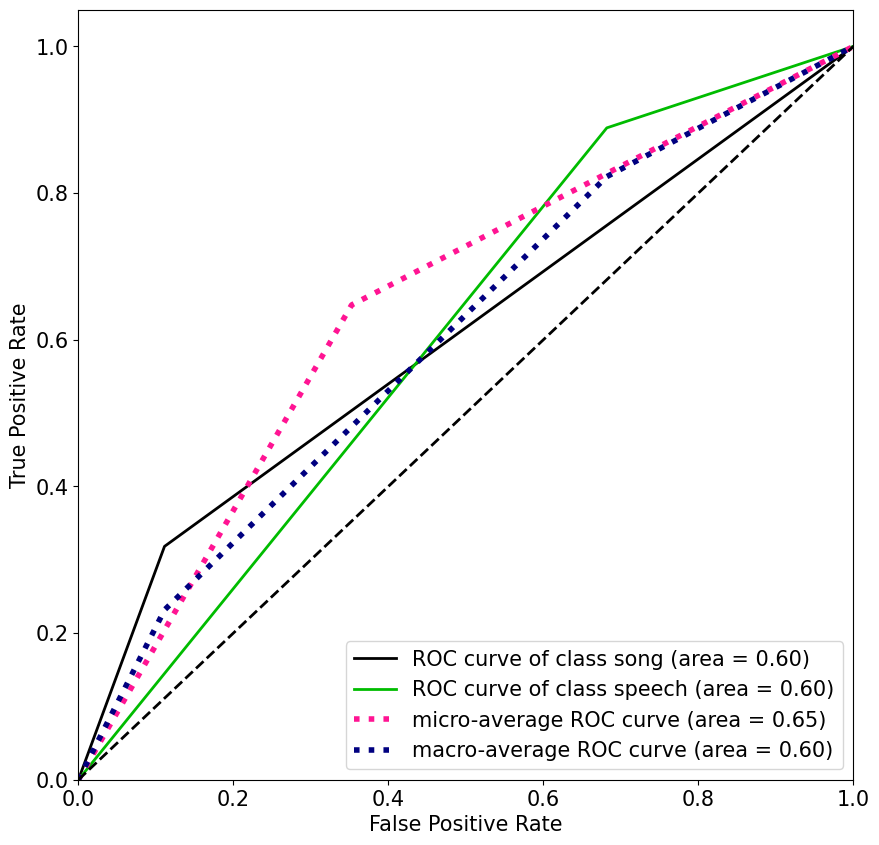

In [71]:
y_score_dft_s = knn_dft_s.predict_proba(x_test_dft)
plot_roc(y_test_s, y_score_dft_s, figsize=(10,10), title_fontsize=15, text_fontsize=15)
plt.title("")
plt.show()

array([[ 84, 180],
       [ 40, 320]])

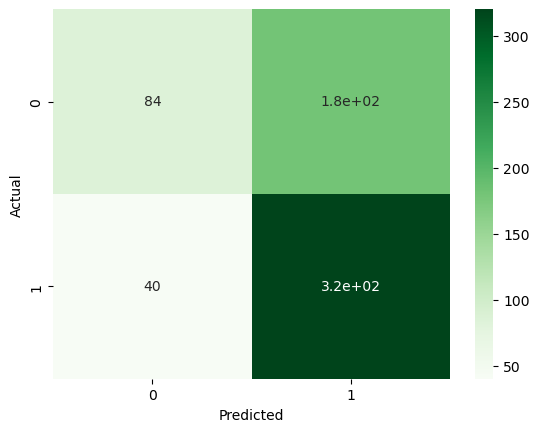

In [72]:
cm_dft_s = confusion_matrix(y_test_s, y_pred_dft_s)
sns.heatmap(cm_dft_s, annot=True, cmap="Greens")
plt.xlabel('Predicted')
plt.ylabel('Actual')
cm_dft_s

NOTA: su questo direi che possiamo dire che non facciamo neanche il tentativo del DTW, visto che già i risultati così sono molto buoni e la spesa di tempo e computazionale per migliorare i risultati con il DTW non è necessaria. <br>
Se poi hai tempo fallo con il DTW, basta che copi da sopra e modifichi con i nomi giusti

<h5>DTW</h5>

In [34]:
from pyts.classification import KNeighborsClassifier #attenzione perchè si chiama uguale!!

In [35]:
%time
param_dist = {
    'n_neighbors': (1,3,5,10,15,30,50),  # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'p': [1, 2],  # Power parameter for the Minkowski metric (1: Manhattan distance, 2: Euclidean distance)
}

knn_dtw=KNeighborsClassifier(metric='dtw_sakoechiba')
random_search_s_dtw = RandomizedSearchCV(knn_dtw, param_distributions=param_dist, n_iter=10, cv=5, random_state=42)
random_search_s_dtw.fit(x_train_dft, y_train_s)
random_search_s_dtw.best_params_

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 8.11 µs


{'weights': 'distance', 'p': 1, 'n_neighbors': 50}

In [36]:
#alleno il modello con i migliori parametri:
knn_dft_s_dtw = KNeighborsClassifier(metric="dtw_sakoechiba", n_neighbors=50, weights="distance", n_jobs=-1)
knn_dft_s_dtw.fit(x_train_dft, y_train_s)

y_pred_dft_s_dtw= knn_dft_s_dtw.predict(x_test_dft)

print('Accuracy %s' % accuracy_score(y_test_s, y_pred_dft_s_dtw))
print('F1-score %s' % f1_score(y_test_s, y_pred_dft_s_dtw, average=None))
print(classification_report(y_test_s, y_pred_dft_s_dtw))

Accuracy 0.7371794871794872
F1-score [0.62211982 0.7985258 ]
              precision    recall  f1-score   support

        song       0.79      0.51      0.62       264
      speech       0.72      0.90      0.80       360

    accuracy                           0.74       624
   macro avg       0.75      0.71      0.71       624
weighted avg       0.75      0.74      0.72       624



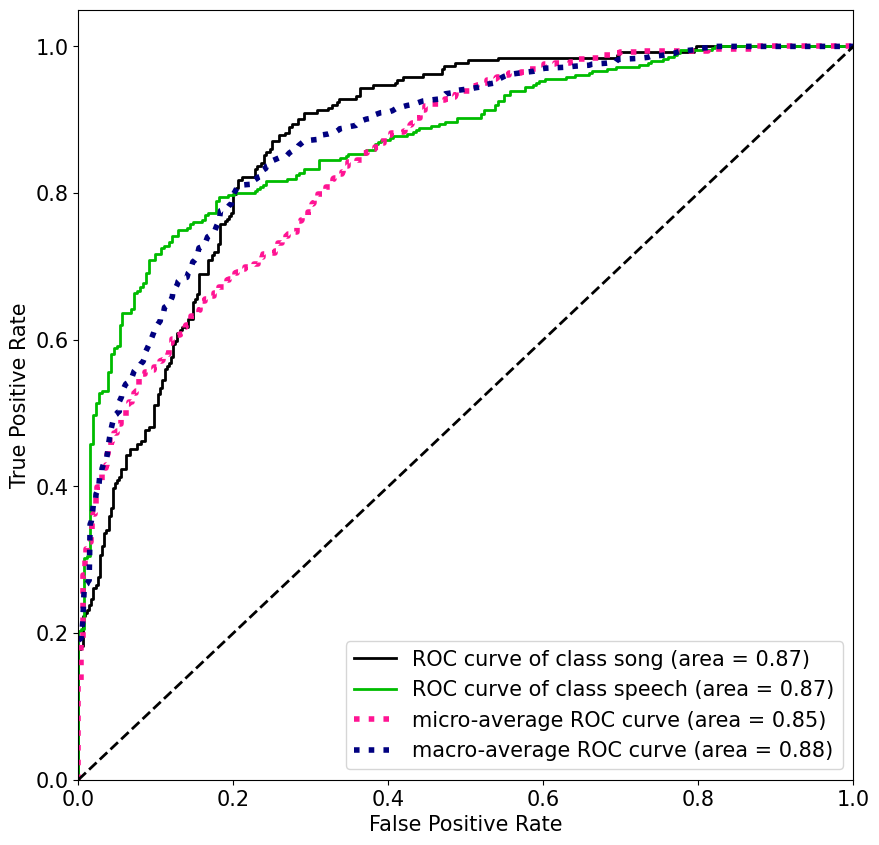

In [37]:
y_score_dft_s_dtw = knn_dft_s_dtw.predict_proba(x_test_dft)
plot_roc(y_test_s, y_score_dft_s_dtw, figsize=(10,10), title_fontsize=15, text_fontsize=15)
plt.title("")
plt.show()

array([[135, 129],
       [ 35, 325]])

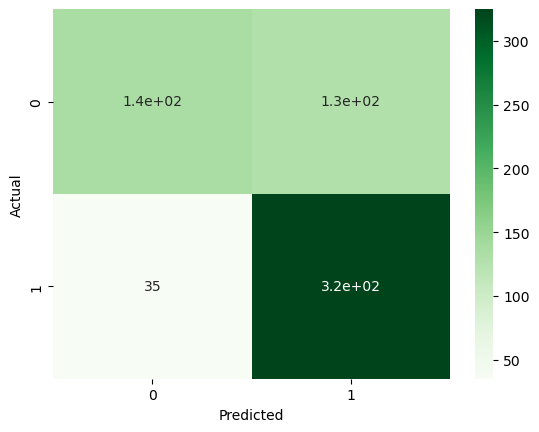

In [38]:
cm_dft_s_dtw = confusion_matrix(y_test_s, y_pred_dft_s_dtw)
sns.heatmap(cm_dft_s_dtw, annot=True, cmap="Greens")
plt.xlabel('Predicted')
plt.ylabel('Actual')
cm_dft_s_dtw

<h3>ROCKET</h3>

Il codice funziona, ma visto che devo ancora vedere la teoria di questo non so bene come funziona. <br>
Potremmo applicarlo a tutte e due le approssimazioni viste sopra, e far vedere che è molto veloce e confrontare i risultati con quelli ottenuti con il knn 

In [77]:
from sklearn.linear_model import RidgeClassifierCV

In [78]:
!pip install sktime

In [86]:
#Nota: per rocket serve versione di Numpy precedente alla 1.22, io ho messo la 1.21:
#!pip install numpy==1.21.0
from sktime.transformations.panel.rocket import Rocket

<h5>DFT</h5>

In [90]:
#Rocket univariate -> ci deve essere una sola colonna
x_train_dftEmb=x_train_dft.reshape(1828,1,64)
x_test_dftEmb=x_test_dft.reshape(624,1,64)

In [92]:
rocket = Rocket()
rocket.fit(x_train_dftEmb)
x_train_transform_rocket = rocket.transform(x_train_dftEmb)
x_test_transform_rocket = rocket.transform(x_test_dftEmb)

In [93]:
clf_R=RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True) 
clf_R.fit(x_train_transform_rocket, y_train)

/Users/dilettaferri/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), _RidgeGCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


RidgeClassifierCV(alphas=array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]),
                  normalize=True)

In [94]:
print(classification_report(y_test, clf_R.predict(x_test_transform_rocket)))

              precision    recall  f1-score   support

       angry       0.37      0.40      0.38        96
        calm       0.31      0.83      0.45        96
     disgust       0.00      0.00      0.00        48
     fearful       0.33      0.20      0.25        96
       happy       0.20      0.23      0.21        96
     neutral       0.00      0.00      0.00        48
         sad       0.16      0.16      0.16        96
   surprised       0.50      0.02      0.04        48

    accuracy                           0.28       624
   macro avg       0.23      0.23      0.19       624
weighted avg       0.25      0.28      0.23       624



/Users/dilettaferri/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dilettaferri/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dilettaferri/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

<H5>SAX</H5>

In [99]:
print(x_train_sax.shape)
print(x_test_sax.shape)


(1828, 500)
(624, 500)


In [100]:
x_train_saxEmb=x_train_sax.reshape(1828,1,500)
x_test_saxEmb=x_test_sax.reshape(624,1,500)

In [101]:
rocket = Rocket()
rocket.fit(x_train_saxEmb)
x_train_transform_rocket_sax = rocket.transform(x_train_saxEmb)
x_test_transform_rocket_sax = rocket.transform(x_test_saxEmb)

In [102]:
clf_R_sax=RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True) 
clf_R_sax.fit(x_train_transform_rocket_sax, y_train)

/Users/dilettaferri/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), _RidgeGCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


RidgeClassifierCV(alphas=array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]),
                  normalize=True)

In [103]:
print(classification_report(y_test, clf_R_sax.predict(x_test_transform_rocket_sax)))

              precision    recall  f1-score   support

       angry       0.00      0.00      0.00        96
        calm       0.15      1.00      0.27        96
     disgust       0.00      0.00      0.00        48
     fearful       0.50      0.01      0.02        96
       happy       0.00      0.00      0.00        96
     neutral       0.00      0.00      0.00        48
         sad       0.00      0.00      0.00        96
   surprised       0.00      0.00      0.00        48

    accuracy                           0.16       624
   macro avg       0.08      0.13      0.04       624
weighted avg       0.10      0.16      0.04       624



/Users/dilettaferri/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dilettaferri/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dilettaferri/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)